PRIMER PARCIAL

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import math
import mlflow

In [66]:
csvToyota= pd.read_csv("ToyotaCorolla_modificado.csv")


TRATAMIENTO DE LA VARIABLE DUMMY

In [67]:
dummies=pd.get_dummies(csvToyota["Fuel_Type"])
csvToyota=csvToyota.drop(columns=["Fuel_Type"])

csvToyota[dummies.columns]=dummies


In [68]:
columns_to_delete=["Id","Model","Age_08_04","Cylinders","Weight","Radio_cassette","Power_Steering","Gears","Automatic","Radio",
                   "Power_Steering","BOVAG_Guarantee","Mfg_Month"]

df_test=csvToyota.drop(columns=columns_to_delete)
df_test.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
Mfg_Year,1436.0,1999.625348,1.540722,1998.0,1998.0,1999.0,2001.00,2004.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
Met_Color,1436.0,0.674791,0.468616,0.0,0.0,1.0,1.00,1.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Quarterly_Tax,1436.0,87.122563,41.128611,19.0,69.0,85.0,85.00,283.0
Mfr_Guarantee,1436.0,0.409471,0.491907,0.0,0.0,0.0,1.00,1.0
Guarantee_Period,1436.0,3.815460,3.011025,3.0,3.0,3.0,3.00,36.0


In [69]:
outlierValuePriceDown=5000
outlierValuePriceUp=19000
df_filtered=df_test[(df_test["Price"]>outlierValuePriceDown)&(df_test["Price"]<=outlierValuePriceUp)]

<h1>CREAR EXPERIMENTO</h1>

In [70]:
experiment_name = 'lasso'

dict_values = {
    'mse':0,
    'r2_adj':0,
    'rmse':0
}


def load_create_experiment():
    if mlflow.get_experiment_by_name(experiment_name):
        return mlflow.get_experiment_by_name(experiment_name)
    return mlflow.create_experiment(experiment_name)
    
current_experiment = load_create_experiment()
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/USUARIO/Desktop/ISI/5to%20a%C3%B1o/Inteligencia%20Empresarial%20y%20Datamining/Actividades/Actividad%205%20-%2010-10-2022/mlruns/5', creation_time=1666708529461, experiment_id='5', last_update_time=1666708529461, lifecycle_stage='active', name='lasso', tags={}>

In [71]:
mlflow.start_run()

<ActiveRun: >

<h1 style="color: cyan">NORMALIZACION</h1>

In [72]:
scaler=MinMaxScaler()
norm_data=scaler.fit_transform(df_filtered)
dataset=pd.DataFrame(norm_data,columns=df_test.columns.values)
dataset.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Price,1372.0,0.369498,0.201772,0.0,0.223827,0.332130,0.458484,1.0
Mfg_Year,1372.0,0.245627,0.230753,0.0,0.000000,0.166667,0.333333,1.0
KM,1372.0,0.289578,0.150218,0.0,0.186151,0.267417,0.364133,1.0
HP,1372.0,0.673531,0.270824,0.0,0.361702,0.872340,0.872340,1.0
Met_Color,1372.0,0.671283,0.469918,0.0,0.000000,1.000000,1.000000,1.0
cc,1372.0,0.018285,0.029302,0.0,0.006803,0.020408,0.020408,1.0
Doors,1372.0,0.670554,0.317496,0.0,0.333333,0.666667,1.000000,1.0
Quarterly_Tax,1372.0,0.308597,0.178434,0.0,0.232558,0.306977,0.306977,1.0
Mfr_Guarantee,1372.0,0.405977,0.491259,0.0,0.000000,0.000000,1.000000,1.0
Guarantee_Period,1372.0,0.024030,0.088498,0.0,0.000000,0.000000,0.000000,1.0


<h3 style="color: lightgreen">MODELO: LASSO</h3>

In [73]:
Y=df_filtered[["Price"]]
X=dataset[["Mfg_Year","KM","Automatic_airco","Airco","Quarterly_Tax","HP","Doors","Mfr_Guarantee"]]

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13392\615492939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Price"]=np.log(Y["Price"])


(array([ 10.,  38., 127., 226., 303., 298., 153.,  91.,  60.,  66.]),
 array([8.54675199, 8.67729622, 8.80784045, 8.93838467, 9.0689289 ,
        9.19947313, 9.33001735, 9.46056158, 9.59110581, 9.72165003,
        9.85219426]),
 <BarContainer object of 10 artists>)

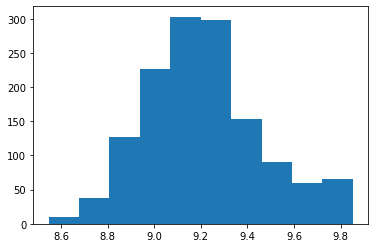

In [74]:
Y["Price"]=np.log(Y["Price"])
plt.hist(Y["Price"],bins=10)

In [75]:
X.shape, Y.shape

((1372, 8), (1372, 1))

In [76]:
datasetsize=X.shape[0]
datasetsize

1372

In [77]:
percentRemoved=0

percentRemoved= (csvToyota.shape[0]-datasetsize)/csvToyota.shape[0] * 100

percentRemoved

4.456824512534819

In [78]:
x_train, x_test, y_train, y_test= train_test_split(X,Y,test_size=0.3,random_state=42,shuffle=True)
x_train=x_train.reset_index(drop=True)
x_test=x_test.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
    

model=sm.OLS(y_train,sm.add_constant(x_train))
ml_results=model.fit()

In [79]:
y_pred = ml_results.predict(sm.add_constant(x_test))

In [80]:
print(y_pred.T)

0      9.251441
1      9.073050
2      9.544266
3      9.444883
4      9.364437
         ...   
407    9.209634
408    9.310099
409    8.865618
410    9.206714
411    9.143333
Length: 412, dtype: float64


In [81]:
mse=mean_squared_error(y_test,y_pred)
print("Mean squared error:" ,mse)

Mean squared error: 0.010474424823439953


In [82]:
print("Root mean squared error: " ,math.sqrt(mse))

Root mean squared error:  0.10234463749234717


In [83]:
summary=ml_results.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     635.8
Date:                Tue, 25 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:38:36   Log-Likelihood:                 820.23
No. Observations:                 960   AIC:                            -1622.
Df Residuals:                     951   BIC:                            -1579.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.9729      0.018    5

In [84]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

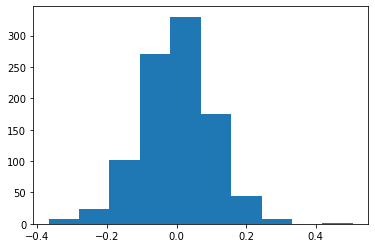

In [85]:
# Residuales
plt.hist(ml_results.resid)
plt.show()

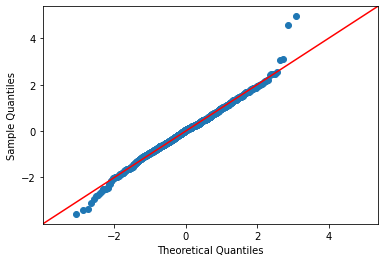

In [86]:
fig = sm.qqplot(lm_resid_stand,line='45')
plt.show()

Text(0, 0.5, 'Residuals')

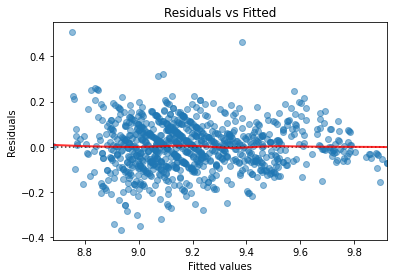

In [87]:
plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                     scatter_kws={'alpha': 0.5},
                     line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')



SCALE LOCATION PLOT

In [97]:
# model values
model_fitted_y = ml_results.fittedvalues
# model residuals
model_residuals = ml_results.resid
# normalized residuals
model_norm_residuals = ml_results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = ml_results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = ml_results.get_influence().cooks_distance[0]

In [98]:
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

c:\Users\USUARIO\.conda\envs\datamining\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


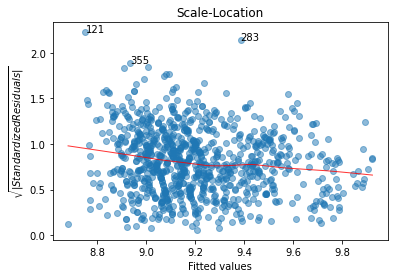

In [99]:
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


<h1 style="color: violet">VALIDACION CON X-VALIDATION</h1>

In [88]:
Y=df_filtered[["Price"]]
X=dataset[["Mfg_Year","KM","Automatic_airco","Airco","Quarterly_Tax","HP","Doors","Mfr_Guarantee"]]

In [89]:
Y["Price"]=np.log(Y["Price"])

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_13392\3880681737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Price"]=np.log(Y["Price"])


In [90]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [91]:
kfold_param = {
    'n_splits':10,
    'shuffle':True,
    'random_state':42
}

kfold = KFold(**kfold_param)

clf_dt = LinearRegression()

score = cross_val_score(clf_dt, X, Y,cv=kfold, n_jobs=-1,scoring="neg_mean_squared_error")

In [92]:
print(score)

[-0.01245131 -0.00708451 -0.0118597  -0.01199441 -0.00856105 -0.01186768
 -0.01131793 -0.01112509 -0.01152191 -0.00959281]


In [93]:
np.mean(abs(score))

0.010737639907977176

In [94]:
math.sqrt(np.mean(abs(score)))

0.10362258396689969

<h1>GUARDAR EXPERIMENTO</h1>

In [95]:
from math import sqrt

dict_values = {
    'mse': mse,
    'r2_adj': ml_results.rsquared_adj,
    'rmse':sqrt(mse),
    'PriceValueTruncDown' : outlierValuePriceDown,
    'PriceValueTruncUp': outlierValuePriceUp
}

mlflow.set_tag('DatasetSize', datasetsize)
mlflow.set_tag('PercentageDataRemoved',percentRemoved)
mlflow.set_tag('Summary',summary)


mlflow.log_metrics(dict_values)

FINALIZAR EXPERIMENTO

In [96]:
mlflow.end_run()